/var/folders/5b/x1zmqcfd0vx4vnnz7ws01y380000gn/T/ipykernel_1799/2764033850.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_category.values[:10], y=fraud_by_category.index[:10], ax=axs[0, 0], palette="Reds_r")
/var/folders/5b/x1zmqcfd0vx4vnnz7ws01y380000gn/T/ipykernel_1799/2764033850.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Non-Fraud', 'Fraud'], y=avg_amounts.values, ax=axs[1, 0], palette='Set2')


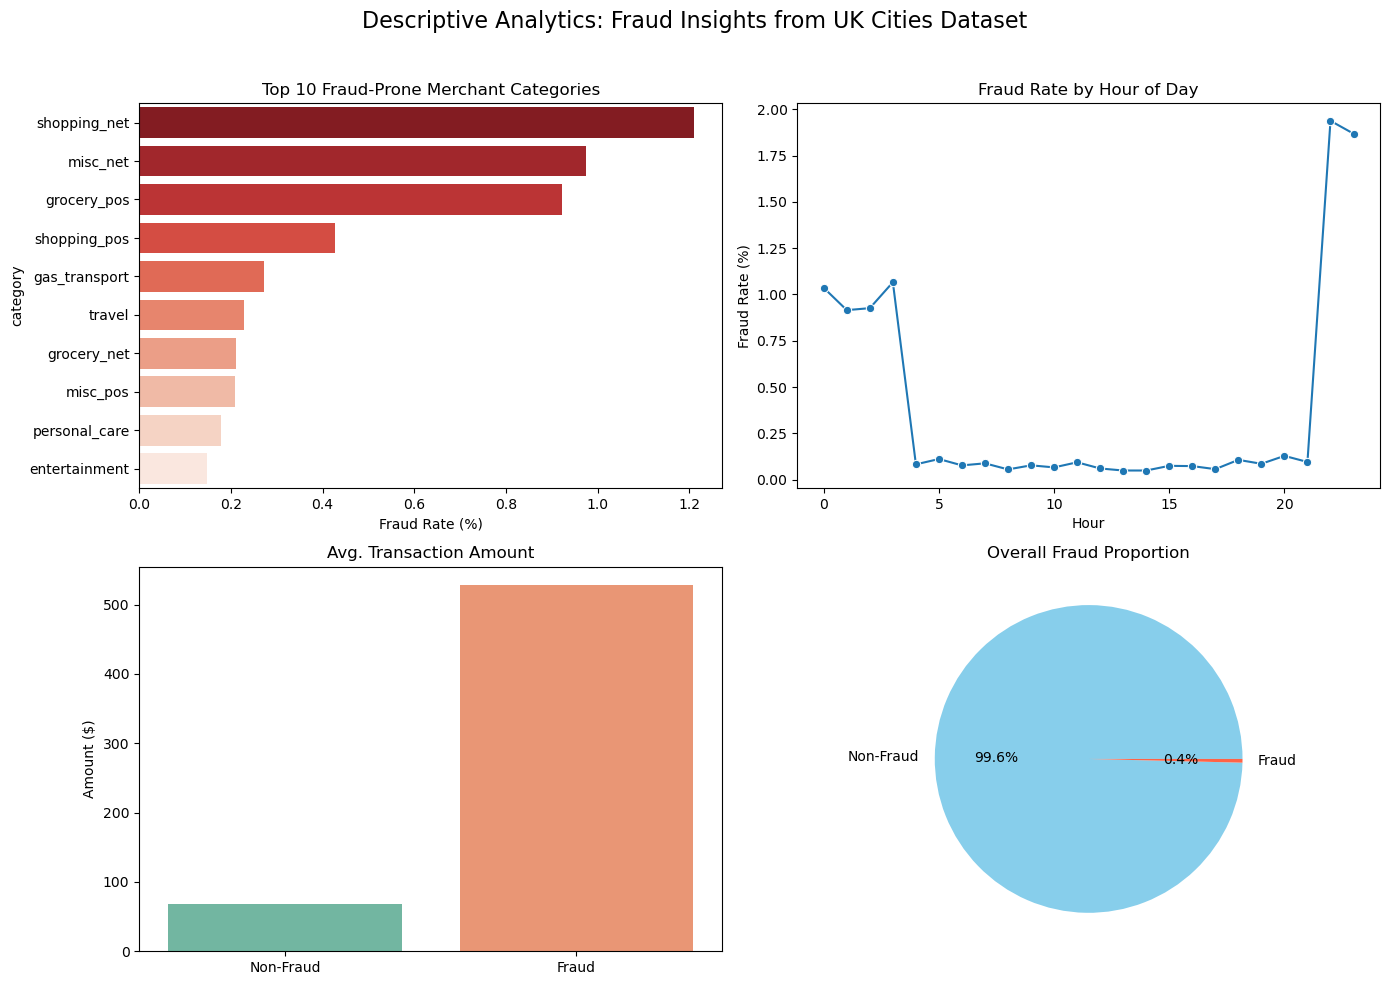

In [1]:
#NOTE:- GRADIO Interface is at the end of page

# libraries and reload the dataset after reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = "fraudTest_uk_cities2.csv"
df = pd.read_csv(file_path)

# overall fraud percentage
total_fraud_pct = df['is_fraud'].mean() * 100

# Fraud by merchant category
fraud_by_category = df.groupby('category')['is_fraud'].mean().sort_values(ascending=False) * 100

# Fraud by city
fraud_by_city = df.groupby('city')['is_fraud'].mean().sort_values(ascending=False) * 100

# Fraud by hour
fraud_by_hour = df.groupby('hour')['is_fraud'].mean() * 100

# Average amount for fraud and non-fraud
avg_amounts = df.groupby('is_fraud')['amt'].mean()


fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Descriptive Analytics: Fraud Insights from UK Cities Dataset', fontsize=16)

# 1. Fraud by Merchant Category
sns.barplot(x=fraud_by_category.values[:10], y=fraud_by_category.index[:10], ax=axs[0, 0], palette="Reds_r")
axs[0, 0].set_title('Top 10 Fraud-Prone Merchant Categories')
axs[0, 0].set_xlabel('Fraud Rate (%)')

# 2. Fraud by Hour
sns.lineplot(x=fraud_by_hour.index, y=fraud_by_hour.values, marker='o', ax=axs[0, 1])
axs[0, 1].set_title('Fraud Rate by Hour of Day')
axs[0, 1].set_xlabel('Hour')
axs[0, 1].set_ylabel('Fraud Rate (%)')

# 3. Average Transaction Amounts
sns.barplot(x=['Non-Fraud', 'Fraud'], y=avg_amounts.values, ax=axs[1, 0], palette='Set2')
axs[1, 0].set_title('Avg. Transaction Amount')
axs[1, 0].set_ylabel('Amount ($)')

# 4. Pie chart of overall fraud vs non-fraud
fraud_counts = df['is_fraud'].value_counts()
axs[1, 1].pie(fraud_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', colors=['skyblue', 'tomato'])
axs[1, 1].set_title('Overall Fraud Proportion')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [2]:
# Adjusted proxy logic 
df['CNP_proxy'] = (
    (df['amt'] > 100) &
    ((df['hour'] < 6) | (df['hour'] > 22))
).astype(int)

df['POS_proxy'] = (
    (df['amt'] <= 100) &
    (df['hour'] >= 9) & (df['hour'] <= 18)
).astype(int)


cnp_fraud_rate = df[df['CNP_proxy'] == 1]['is_fraud'].mean()
pos_fraud_rate = df[df['POS_proxy'] == 1]['is_fraud'].mean()

# Count of transactions in each proxy group
cnp_count = df['CNP_proxy'].sum()
pos_count = df['POS_proxy'].sum()

{
    "CNP Fraud Rate": f"{cnp_fraud_rate:.2%} ({cnp_count} transactions)",
    "POS Fraud Rate": f"{pos_fraud_rate:.2%} ({pos_count} transactions)"
}

{'CNP Fraud Rate': '3.44% (29046 transactions)',
 'POS Fraud Rate': '0.02% (209593 transactions)'}

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df['CNP_proxy'] = (
    (df['amt'] > 100) &
    ((df['hour'] < 6) | (df['hour'] > 22))
).astype(int)

df['POS_proxy'] = (
    (df['amt'] <= 100) &
    (df['hour'] >= 9) & (df['hour'] <= 18)
).astype(int)

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder


# === Feature Engineering ===

# Proxy flags for behavioral patterns
df['CNP_proxy'] = ((df['amt'] > 100) & ((df['hour'] < 6) | (df['hour'] > 22))).astype(int)
df['POS_proxy'] = ((df['amt'] <= 100) & (df['hour'] >= 9) & (df['hour'] <= 18)).astype(int)

# Temporal indicators
df['is_night'] = ((df['hour'] >= 21) | (df['hour'] < 6)).astype(int)
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Haversine distance
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c

df['distance_to_merchant_km'] = haversine_np(df['long'], df['lat'], df['merch_long'], df['merch_lat'])


drop_cols = ['trans_date_trans_time', 'first', 'last', 'street', 'job', 'dob', 'unix_time']
df.drop(columns=drop_cols, inplace=True, errors='ignore')


categorical_cols = ['merchant', 'category', 'city', 'state']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Final feature matrix and target
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Final check
print(" Final feature matrix shape:", X.shape)
print(" Features used:", X.columns.tolist())

 Final feature matrix shape: (555719, 28)
 Features used: ['Unnamed: 0', 'cc_num', 'merchant', 'category', 'amt', 'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'trans_num', 'merch_lat', 'merch_long', 'hour', 'day_of_week', 'day', 'month', 'is_night', 'is_weekend', 'txn_count_per_card', 'avg_amt_per_card', 'amt_diff_from_avg', 'time_since_first_txn_hrs', 'distance_to_merchant_km', 'CNP_proxy', 'POS_proxy']


In [4]:

X = df.drop(columns=['is_fraud'], errors='ignore')
y = df['is_fraud']

if 'trans_num' in X.columns:
    X.drop(columns=['trans_num'], inplace=True)

if 'gender' in X.columns:
    X['gender'] = X['gender'].map({'M': 0, 'F': 1})

for col in X.columns:
    if X[col].dtype == 'object':
        print(f"Dropping invalid object column: {col}")
        X.drop(columns=[col], inplace=True)

print(" XGBoost-safe feature dtypes:")
print(X.dtypes.value_counts())

 XGBoost-safe feature dtypes:
int64      18
float64     9
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split

# Split the data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

print(" Train size:", X_train.shape)
print(" Test size:", X_test.shape)
print(" Fraud rate in Train set:", round(y_train.mean() * 100, 4), "%")
print(" Fraud rate in Test set:", round(y_test.mean() * 100, 4), "%")


 Train size: (389003, 27)
 Test size: (166716, 27)
 Fraud rate in Train set: 0.3859 %
 Fraud rate in Test set: 0.3863 %


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

X_baseline = df.drop(columns=['is_fraud', 'trans_num', 'gender'])
y_baseline = df['is_fraud']

# Train-test split for baseline model
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_baseline, y_baseline, test_size=0.3, stratify=y_baseline, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_baseline)
X_test_scaled = scaler.transform(X_test_baseline)

# Train Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train_baseline)

y_pred_baseline = logreg.predict(X_test_scaled)
y_pred_proba_baseline = logreg.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
print("Baseline Model - Logistic Regression:")
print(classification_report(y_test_baseline, y_pred_baseline))
print("Confusion Matrix:\n", confusion_matrix(y_test_baseline, y_pred_baseline))
print(f"ROC AUC: {roc_auc_score(y_test_baseline, y_pred_proba_baseline):.4f}")


Baseline Model - Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    166072
           1       0.67      0.09      0.16       644

    accuracy                           1.00    166716
   macro avg       0.84      0.55      0.58    166716
weighted avg       1.00      1.00      0.99    166716

Confusion Matrix:
 [[166043     29]
 [   584     60]]
ROC AUC: 0.9188


<Figure size 600x600 with 0 Axes>

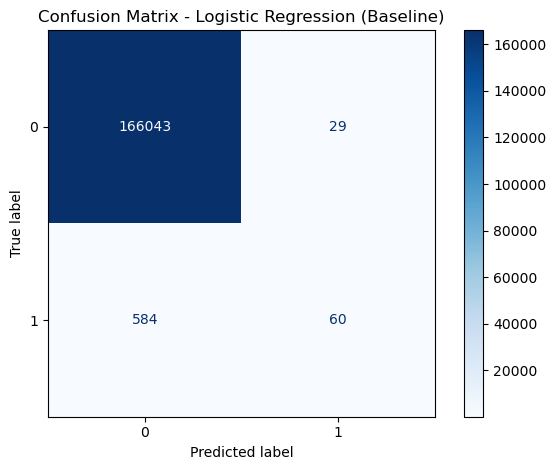

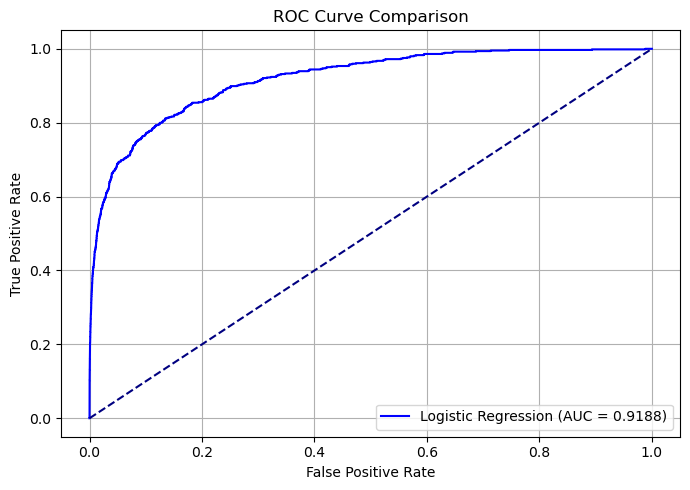

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# Confusion Matrix for Baseline Model (Logistic Regression)
plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test_baseline, y_pred_baseline, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Logistic Regression (Baseline)")
plt.tight_layout()
plt.show()

# ROC AUC Curve for Baseline Model
fpr_baseline, tpr_baseline, _ = roc_curve(y_test_baseline, y_pred_proba_baseline)
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)


# ROC Curves
plt.figure(figsize=(7, 5))
plt.plot(fpr_baseline, tpr_baseline, color='blue', label=f"Logistic Regression (AUC = {roc_auc_baseline:.4f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
!pip install xgboost


In [9]:
# Train and evaluate XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
roc_auc = roc_auc_score(y_test, y_pred_proba)

{
    "Confusion Matrix": conf_matrix.tolist(),
    "Precision": round(report["1"]["precision"], 4),
    "Recall": round(report["1"]["recall"], 4),
    "F1 Score": round(report["1"]["f1-score"], 4),
    "ROC AUC": round(roc_auc, 4)
}

/Applications/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:37:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'Confusion Matrix': [[166034, 38], [139, 505]],
 'Precision': 0.93,
 'Recall': 0.7842,
 'F1 Score': 0.8509,
 'ROC AUC': 0.9928}

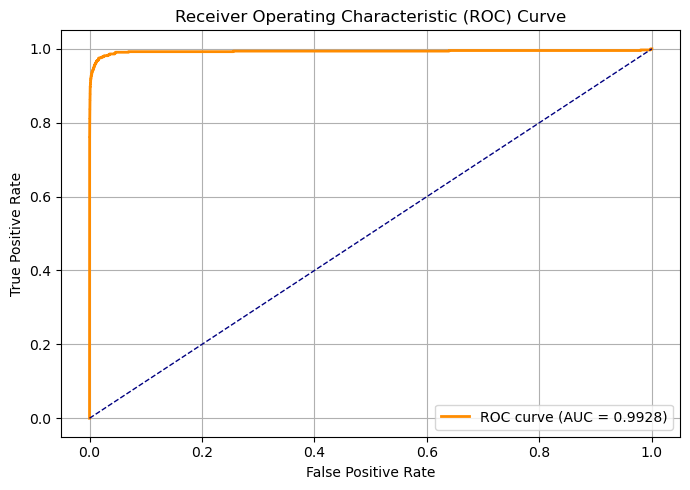

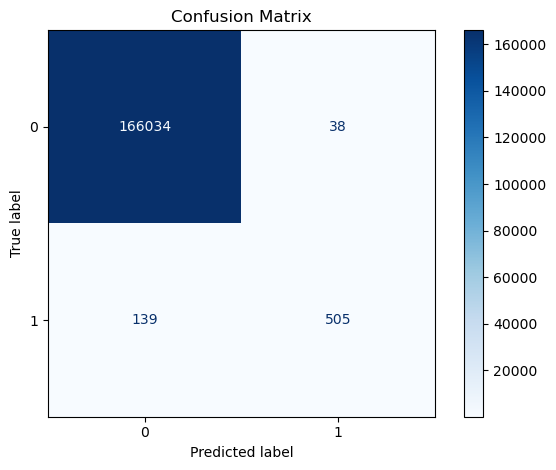

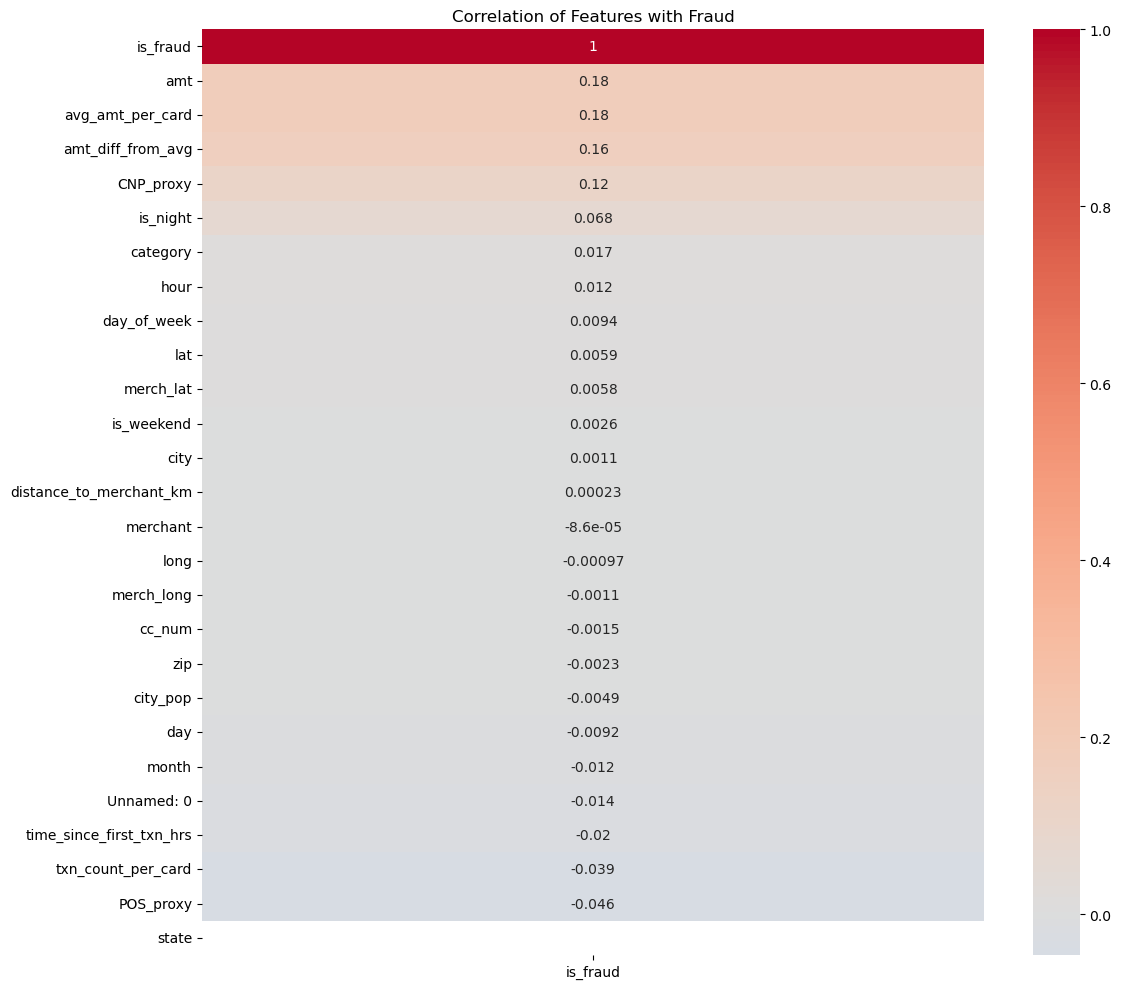

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Correlation heatmap with 'is_fraud'
plt.figure(figsize=(12, 10))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix[['is_fraud']].sort_values(by='is_fraud', ascending=False), 
            annot=True, cmap='coolwarm', center=0)
plt.title("Correlation of Features with Fraud")
plt.tight_layout()
plt.show()


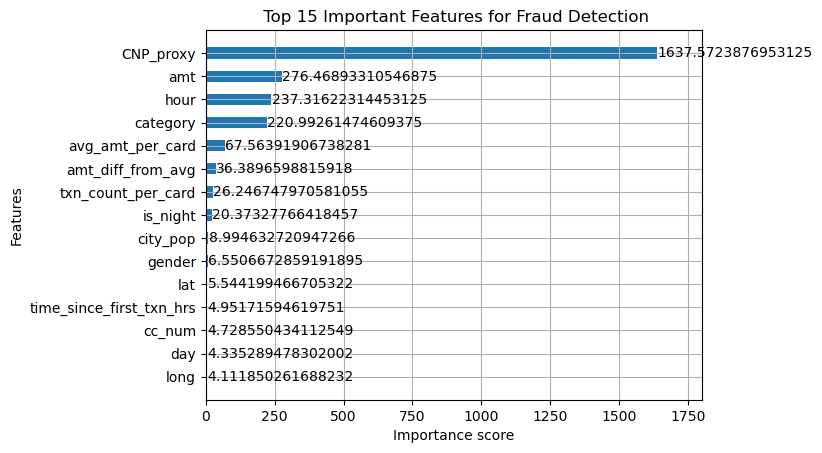

In [11]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot top 15 important features
xgb.plot_importance(model, max_num_features=15, importance_type='gain', height=0.5)
plt.title(" Top 15 Important Features for Fraud Detection")
plt.show()


In [12]:
import numpy as np
from sklearn.metrics import precision_recall_curve


precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# threshold 
new_threshold = 0.7
y_pred_threshold = (y_pred_proba >= new_threshold).astype(int)

# Metrics at this threshold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(f"Threshold: {new_threshold}")
print("Precision, Recall, F1 Score:\n", classification_report(y_test, y_pred_threshold))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_threshold))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")


Threshold: 0.7
Precision, Recall, F1 Score:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    166072
           1       0.96      0.73      0.83       644

    accuracy                           1.00    166716
   macro avg       0.98      0.87      0.91    166716
weighted avg       1.00      1.00      1.00    166716

Confusion Matrix:
 [[166050     22]
 [   173    471]]
ROC AUC: 0.9928


In [44]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the hyperparameters grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=2, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best hyperparameters from GridSearchCV
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Get the best model
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 324 candidates, totalling 972 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:26:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:26:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:26:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:26:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}
Best score: 0.9989460235657205


In [13]:
# Retrain the final model using the best hyperparameters from GridSearchCV
best_params = {
    'colsample_bytree': 0.8,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 10,
    'n_estimators': 200,
    'subsample': 1.0
}


final_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)

final_model.fit(X_train, y_train)

y_pred_final = final_model.predict(X_test)
y_pred_proba_final = final_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(f"Classification Report:\n{classification_report(y_test, y_pred_final)}")

# Confusion Matrix
conf_matrix_final = confusion_matrix(y_test, y_pred_final)
print(f"Confusion Matrix:\n{conf_matrix_final}")

# ROC AUC
roc_auc_final = roc_auc_score(y_test, y_pred_proba_final)
print(f"ROC AUC: {roc_auc_final:.4f}")


/Applications/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:37:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    166072
           1       0.96      0.82      0.88       644

    accuracy                           1.00    166716
   macro avg       0.98      0.91      0.94    166716
weighted avg       1.00      1.00      1.00    166716

Confusion Matrix:
[[166050     22]
 [   119    525]]
ROC AUC: 0.9992


<Figure size 600x600 with 0 Axes>

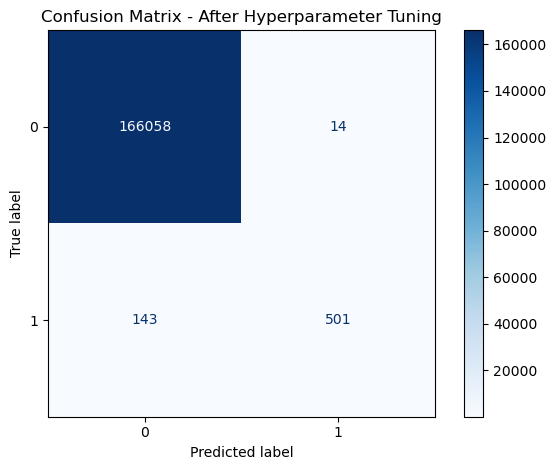

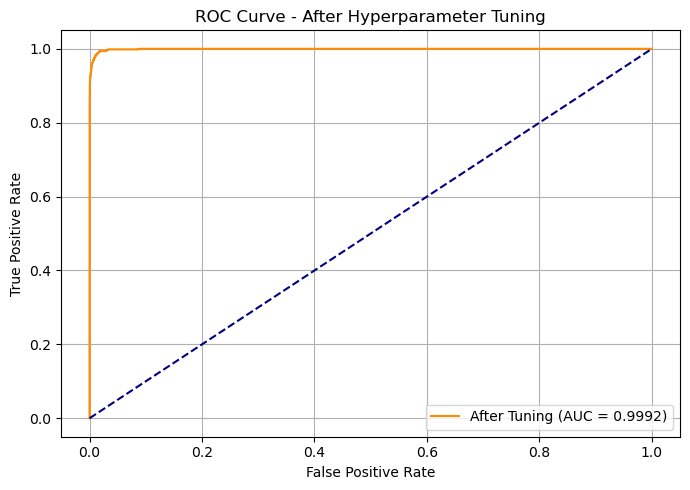

In [14]:
# Set threshold to 0.7 for predictions (after hyperparameter tuning)
y_pred_after = (y_pred_proba_final >= 0.7).astype(int)

# Confusion Matrix after hyperparameter tuning
plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_after, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - After Hyperparameter Tuning")
plt.tight_layout()
plt.show()

# ROC AUC Curve after hyperparameter tuning
fpr_after, tpr_after, _ = roc_curve(y_test, y_pred_proba_final)
roc_auc_after = auc(fpr_after, tpr_after)

plt.figure(figsize=(7, 5))
plt.plot(fpr_after, tpr_after, color='darkorange', label=f"After Tuning (AUC = {roc_auc_after:.4f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - After Hyperparameter Tuning")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 600x600 with 0 Axes>

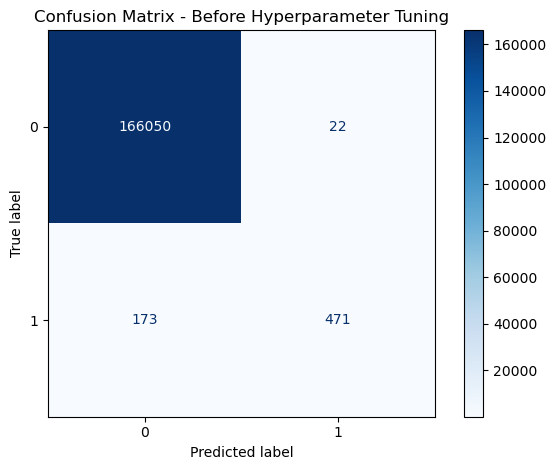

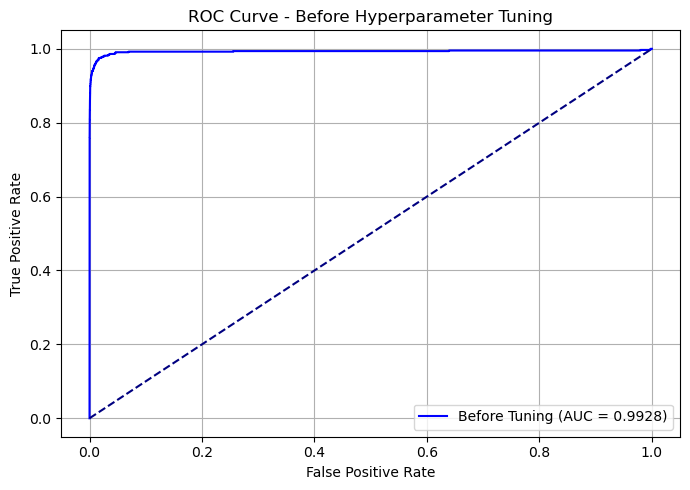

In [15]:
# Set threshold to 0.7 for predictions
y_pred_before = (y_pred_proba >= 0.7).astype(int)

# Confusion Matrix before hyperparameter tuning
plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_before, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Before Hyperparameter Tuning")
plt.tight_layout()
plt.show()

# ROC AUC Curve before hyperparameter tuning
fpr_before, tpr_before, _ = roc_curve(y_test, y_pred_proba)
roc_auc_before = auc(fpr_before, tpr_before)

plt.figure(figsize=(7, 5))
plt.plot(fpr_before, tpr_before, color='blue', label=f"Before Tuning (AUC = {roc_auc_before:.4f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Before Hyperparameter Tuning")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
!pip install shap


  Using cached shap-0.47.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
Using cached shap-0.47.1-cp312-cp312-macosx_11_0_arm64.whl (492 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   6.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=1.0; total time=   4.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.7s
[CV]

  1%|                   | 1169/166716 [00:12<28:19]       

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   6.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8; total time=   4.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.8; total time=   8.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.6s
[

  1%|                   | 1273/166716 [00:13<28:09]       

s=100, subsample=0.8; total time=   6.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=10, n_estimators=200, subsample=0.8; total time=   7.9s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   5.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   8.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.8; total time=  11.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimator

  1%|                   | 1377/166716 [00:14<28:01]       

e=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   6.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time=   5.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   9.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=10, n_estimators=100, subsample=0.8; total time=   7.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=1.0; total time=   8.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0.2, lea

  1%|                   | 1482/166716 [00:15<27:52]       

ning_rate=0.1, max_depth=10, n_estimators=50, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, subsample=1.0; total time=   5.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, n_estimators=50, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0

  1%|                   | 1691/166716 [00:17<27:39]       

ND colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8; total time=   5.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.8; total time=  10.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   4.4s
[CV] END

  1%|                   | 1797/166716 [00:18<27:31]       

_rate=0.01, max_depth=10, n_estimators=50, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8; total time=   6.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, subsample=1.0; total time=  10.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   5.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time=   4.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   8.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_

  1%|                   | 1904/166716 [00:19<27:24]       

me=   8.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, n_estimators=50, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, n_estimators=50, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.8; total time=   7.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=10, n_estimators=50, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=10, n_estimators=200, subsample=0.8; total time=   8.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; 

  1%|                   | 2011/166716 [00:20<27:18]       

s=200, subsample=0.8; total time=  16.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   4.9s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   8.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time=  13.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, subsample=1.0; total time=   5.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.8; total time=  18.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, n_e

100%|===================| 166708/166716 [78:05<00:00]        

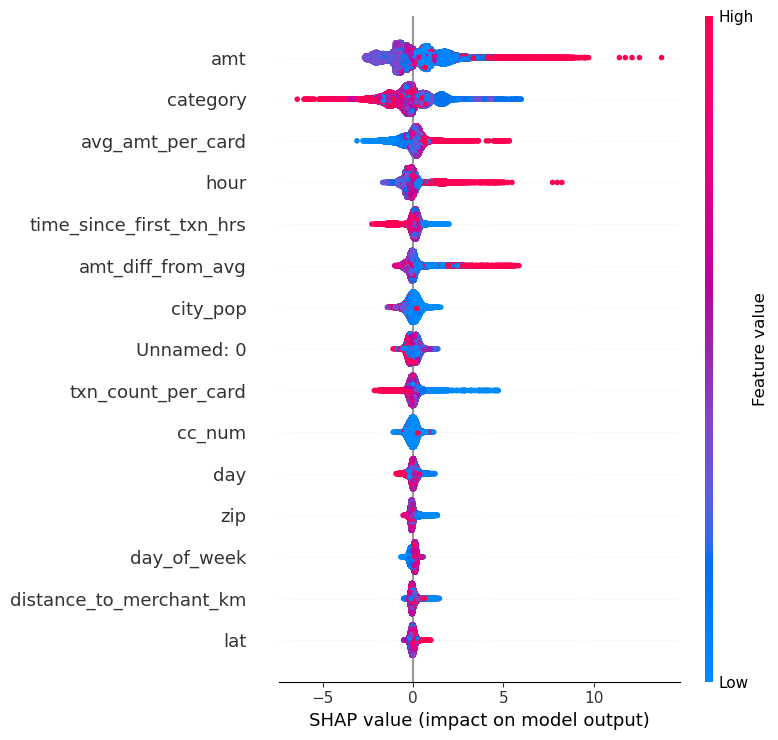

In [54]:
# Feature Importance for XGBoost
import shap

# SHAP Feature Importance Plot
explainer = shap.Explainer(final_model, X_test)
shap_values = explainer(X_test)

# Summary plot for feature importance
shap.summary_plot(shap_values, X_test, max_display=15)

In [17]:
pip install joblib


Note: you may need to restart the kernel to use updated packages.


In [18]:
import joblib

# Save the trained model
joblib.dump(final_model, "xgboost_model.joblib")

# Saving threshold separately 
with open("threshold.txt", "w") as f:
    f.write("0.7")


In [19]:
# Load the trained model
model = joblib.load("xgboost_model.joblib")

# Load the threshold
with open("threshold.txt", "r") as f:
    threshold = float(f.read())


In [20]:
# Full list from training
features = ['Unnamed: 0', 'cc_num', 'merchant', 'category', 'amt', 'gender', 'city', 'state', 'zip', 'lat', 'long',
            'city_pop', 'merch_lat', 'merch_long', 'hour', 'day_of_week', 'day', 'month', 'is_night', 'is_weekend',
            'txn_count_per_card', 'avg_amt_per_card', 'amt_diff_from_avg', 'time_since_first_txn_hrs',
            'distance_to_merchant_km', 'CNP_proxy', 'POS_proxy']

# Create a default input with 0s
input_dict = {col: 0 for col in features}

# test values
input_dict.update({
    'amt': 250,
    'hour': 2,
    'is_night': 1,
    'is_weekend': 1,
    'distance_to_merchant_km': 3.5,
    'CNP_proxy': 1,
    'POS_proxy': 0,
    
    # dummy placeholders 
    'Unnamed: 0': 1,
    'cc_num': 1234567890,
    'merchant': 5,
    'category': 2,
    'gender': 1,
    'city': 3,
    'state': 1,
    'zip': 12345,
    'lat': 51.5,
    'long': -0.1,
    'city_pop': 500000,
    'merch_lat': 51.6,
    'merch_long': -0.12,
    'day_of_week': 5,
    'day': 12,
    'month': 4,
    'txn_count_per_card': 5,
    'avg_amt_per_card': 220,
    'amt_diff_from_avg': 30,
    'time_since_first_txn_hrs': 48
})


new_data = pd.DataFrame([input_dict])
 
prob = model.predict_proba(new_data)[:, 1][0]
pred = "FRAUD" if prob >= threshold else "NOT FRAUD"

print(f"Prediction: {pred} (Probability: {prob:.2f})")


Prediction: NOT FRAUD (Probability: 0.12)


In [21]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [22]:
import gradio as gr
import pandas as pd
import joblib

# Loading model
model = joblib.load("xgboost_model.joblib")
with open("threshold.txt", "r") as f:
    threshold = float(f.read())

# List of features used in training
features = ['Unnamed: 0', 'cc_num', 'merchant', 'category', 'amt', 'gender', 'city', 'state', 'zip', 'lat', 'long',
            'city_pop', 'merch_lat', 'merch_long', 'hour', 'day_of_week', 'day', 'month', 'is_night', 'is_weekend',
            'txn_count_per_card', 'avg_amt_per_card', 'amt_diff_from_avg', 'time_since_first_txn_hrs',
            'distance_to_merchant_km', 'CNP_proxy', 'POS_proxy']

# Defining  fraud prediction function
def predict_fraud(amt, hour, distance, is_weekend):
    is_night = 1 if hour >= 21 or hour < 6 else 0
    cnp_proxy = 1 if (amt > 100 and (hour < 6 or hour > 22)) else 0
    pos_proxy = 1 if (amt <= 100 and 9 <= hour <= 18) else 0

    input_dict = {col: 0 for col in features}
    input_dict.update({
        'amt': amt,
        'hour': hour,
        'distance_to_merchant_km': distance,
        'is_weekend': int(is_weekend),
        'is_night': is_night,
        'CNP_proxy': cnp_proxy,
        'POS_proxy': pos_proxy,
        
        # Dummy placeholders for remaining features
        'Unnamed: 0': 999, 'cc_num': 1234567890, 'merchant': 1, 'category': 2, 'gender': 1,
        'city': 3, 'state': 2, 'zip': 10101, 'lat': 51.5, 'long': -0.1,
        'city_pop': 500000, 'merch_lat': 51.6, 'merch_long': -0.12, 'day_of_week': 3,
        'day': 14, 'month': 4, 'txn_count_per_card': 5, 'avg_amt_per_card': 220,
        'amt_diff_from_avg': amt - 220, 'time_since_first_txn_hrs': 48
    })

    df = pd.DataFrame([input_dict])
    proba = model.predict_proba(df)[:, 1][0]
    label = "FRAUD" if proba >= threshold else "NOT FRAUD"
    return f"{label} (Probability: {proba:.2f})"

# Gradio interface
app = gr.Interface(
    fn=predict_fraud,
    inputs=[
        gr.Number(label="Transaction Amount"),
        gr.Slider(0, 23, label="Transaction Hour"),
        gr.Number(label="Distance to Merchant (km)"),
        gr.Checkbox(label="Weekend Transaction?")
    ],
    outputs="text",
    title="Credit Card Fraud Detector",
    description="Enter transaction details to simulate fraud prediction using a trained XGBoost model."
)

app.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
